In [1]:
import platform 
operating_system = platform.system()
print(operating_system)

Linux


In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, "/home/dotson/research/cairo")
if operating_system is 'Linux':
    sys.path.insert(0, "/home/dotson/research/cairo")
    
elif operating_system is 'Windows':
    sys.path.insert(0, "C:/users/samgd/research/cairo")


# custom libraries
from tools import MSE, esn_prediction, param_string, optimal_values
from optimizers import grid_optimizer_parallel, grid_optimizer
from sunrise import generate_elevation_series
from pyESN.pyESN import ESN

In [3]:
# import demand data
dataframe = pd.read_csv("../data/uiuc_demand_data.csv", usecols=['time','kw'])
demand = np.array(dataframe.kw).astype('float64')

# normalize
norm = np.linalg.norm(demand)
demand_norm = demand/norm

In [4]:
time_range = pd.date_range(start='1/1/2015', end='7/1/2019', freq='h')[:-2]
elevation = generate_elevation_series(time_range, timestamps=True)
norm_a = np.linalg.norm(elevation)
angles_norm = elevation/norm_a
print(f"Norm of elevation angles: {norm_a}")
print(f"Norm of demand: {norm}")

Norm of elevation angles: 7170.040655802196
Norm of demand: 10142199.043147163


In [5]:
X_in = np.concatenate([[demand_norm, angles_norm]], axis=1)
    
print(f"Shape of X_in is {X_in.shape}")

Shape of X_in is (2, 39407)


In [6]:
# optimal parameters from demand-windowsize
params = {'n_reservoir':100, 
          'sparsity':0.03, 
          'rand_seed':85, 
          'rho':1.5, 
          'noise':0.0001, 
          'future':72, 
          'window':72, 
          'trainlen':500}

rand_seeds = [85, 232,12, 33, 45, 19, 29, 402, 222, 13139]

In [7]:
futureTotal = params['future']
time_range = np.array(dataframe.time)
hour_range = np.arange(0, len(time_range), 1)

In [8]:
N = len(rand_seeds)
predictions = np.ones((N, futureTotal))

tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(X_in.T, params)
    predictions[x] = prediction.T[0]
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
Running Simulation 7
Running Simulation 8
Running Simulation 9
This simulation took 0.22 seconds
This simulation took 0.00 minutes


In [9]:
mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

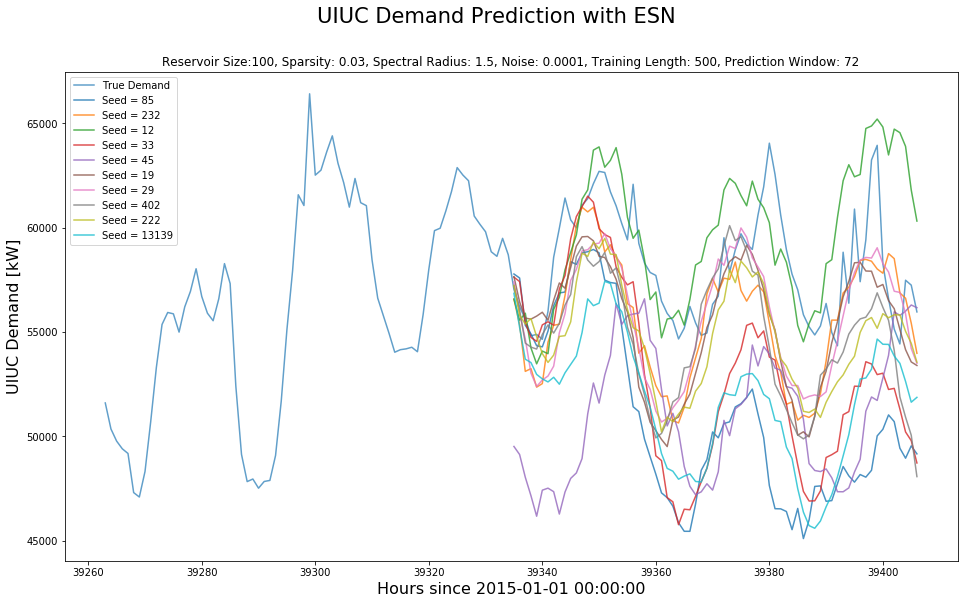

In [10]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
for seed, pred in zip(rand_seeds, predictions):
    plt.plot(hour_range[-futureTotal:], norm*pred,  alpha=0.8, 
             label=f'Seed = {seed}',
             linestyle='-')
plt.legend()

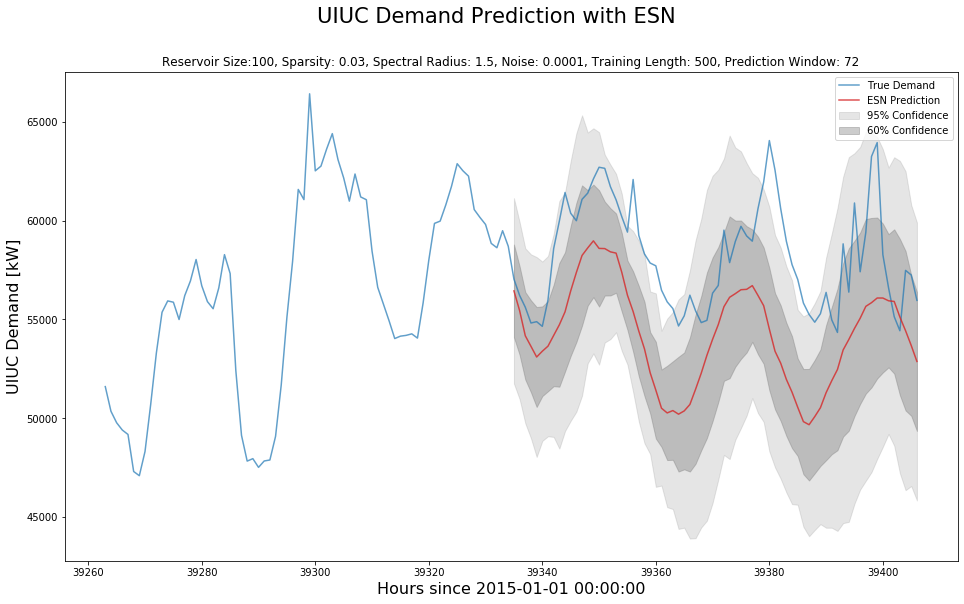

In [11]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*mean_prediction,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + 2 * std_prediction),
                 norm*(mean_prediction - 2 * std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + std_prediction),
                 norm*(mean_prediction - std_prediction),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()

In [12]:
def update_params(xval, xvar, params):
    """
    This function creates a list of parameter
    dictionaries for multiprocessing.
    """
    new_params = params.copy()
    new_params[xvar] = xval
    
    return new_params

In [13]:
params_list = [update_params(x, 'rand_seed', params) for x in rand_seeds]
len(params_list)

10

In [14]:
X_in.T.shape

(39407, 2)

In [15]:
import concurrent.futures as cf

In [16]:
N = len(rand_seeds)
Npredictions = np.ones((N, futureTotal))

tic = time.perf_counter()

with cf.ProcessPoolExecutor() as executor:
    x_train = np.array([X_in.T for i in rand_seeds])
    results = executor.map(esn_prediction, x_train, params_list)
#     results = [executor.submit(esn_prediction, x, p) for x,p in zip([X_in.T for _ in rand_seeds], params_list)]
#     print(list(results))
#     for result in results:
#         print(result)
    
    for i, result in enumerate(results):
        Npredictions[i] = result.T[0]
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 0.36 seconds
This simulation took 0.01 minutes


In [17]:
parallel_mean_prediction = np.mean(Npredictions, axis=0)
parallel_std_prediction = np.std(Npredictions, axis=0)

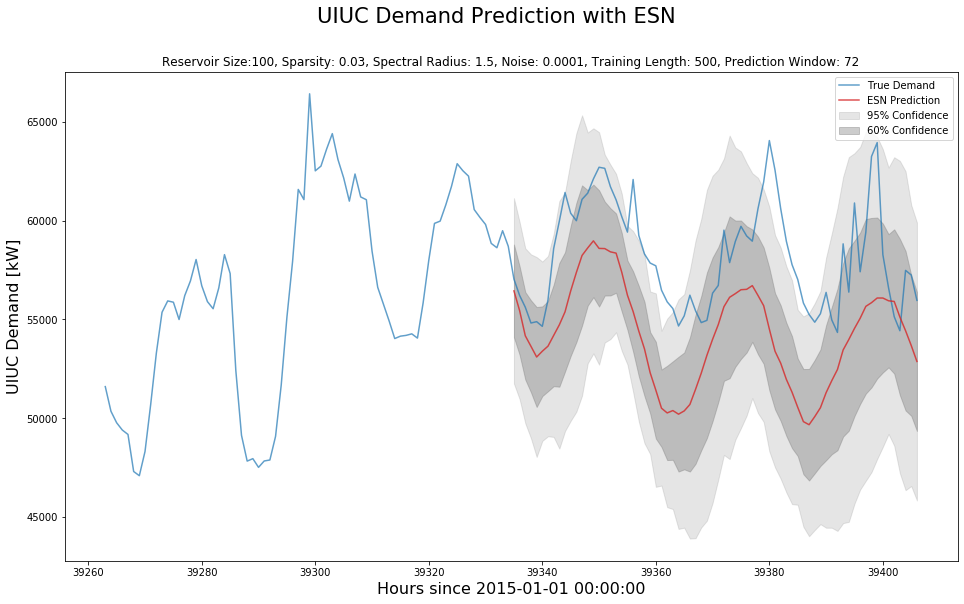

In [18]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*parallel_mean_prediction,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(parallel_mean_prediction + 2 * parallel_std_prediction),
                 norm*(parallel_mean_prediction - 2 * parallel_std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(parallel_mean_prediction + parallel_std_prediction),
                 norm*(parallel_mean_prediction - parallel_std_prediction),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()

Optimizing over ['trainlen']:
trainlen = 200, MSE=0.0009259318250950825
trainlen = 202, MSE=0.0013248418735665624
trainlen = 204, MSE=0.0006958502904460252
trainlen = 206, MSE=0.0011227094069294365
trainlen = 208, MSE=0.0017149332955102043
trainlen = 210, MSE=0.000872941033098771
trainlen = 212, MSE=0.001961987195075151
trainlen = 214, MSE=0.001400507258940691
trainlen = 216, MSE=0.0016707190742048501
trainlen = 218, MSE=0.0021852293027262567
trainlen = 220, MSE=0.0012372355449281373
trainlen = 222, MSE=0.0018727933168642408
trainlen = 224, MSE=0.0008903628177015183
trainlen = 226, MSE=0.0009083367954646021
trainlen = 228, MSE=0.000991205659610558
trainlen = 230, MSE=0.0019576467248340486
trainlen = 232, MSE=0.0011579145956537409
trainlen = 234, MSE=0.0007198904273441998
trainlen = 236, MSE=0.002232593345380612
trainlen = 238, MSE=0.000708194795747495
trainlen = 240, MSE=0.0007758417215870176
trainlen = 242, MSE=0.0007115245790706154
trainlen = 244, MSE=0.0005831567375163762
trainlen =

trainlen = 592, MSE=0.0009498300014939171
trainlen = 594, MSE=0.0007506686995261268
trainlen = 596, MSE=0.0012046428827422828
trainlen = 598, MSE=0.001299680906519981
trainlen = 600, MSE=0.001042472616256615
trainlen = 602, MSE=0.0011006905317416298
trainlen = 604, MSE=0.001270518276090651
trainlen = 606, MSE=0.0010996666262542026
trainlen = 608, MSE=0.0007243289851572894
trainlen = 610, MSE=0.0006025302783777754
trainlen = 612, MSE=0.000508609716475555
trainlen = 614, MSE=0.000686237699918105
trainlen = 616, MSE=0.0005578331609635996
trainlen = 618, MSE=0.0004959877319085685
trainlen = 620, MSE=0.000634639633644845
trainlen = 622, MSE=0.0006781541032637759
trainlen = 624, MSE=0.0006670629217978292
trainlen = 626, MSE=0.0008002440078351166
trainlen = 628, MSE=0.0008034046796423837
trainlen = 630, MSE=0.0009266717937649599
trainlen = 632, MSE=0.000960759522923836
trainlen = 634, MSE=0.0005709406495495319
trainlen = 636, MSE=0.0005790357299240771
trainlen = 638, MSE=0.0007032795472294976

trainlen = 984, MSE=0.0007453894253289632
trainlen = 986, MSE=0.0006145989202071305
trainlen = 988, MSE=0.0005702682869949697
trainlen = 990, MSE=0.0005114151212635708
trainlen = 992, MSE=0.0006181952733057587
trainlen = 994, MSE=0.0006542673076258298
trainlen = 996, MSE=0.0009075553601336587
trainlen = 998, MSE=0.00133261806044005
This simulation took 32.90 seconds
This simulation took 0.55 minutes


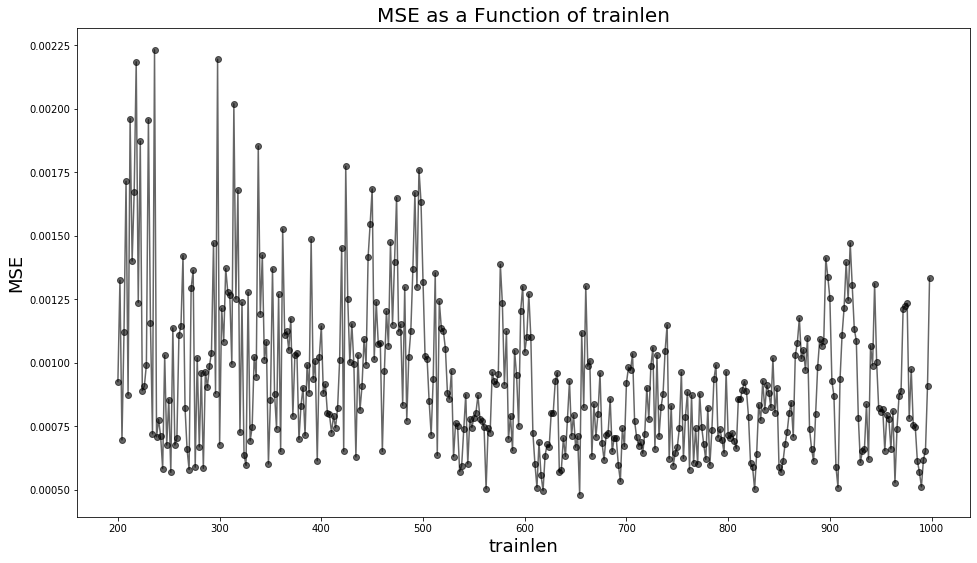

In [19]:
tic = time.perf_counter()
trainingLengths = np.arange(200,1000,2)
trainlen_loss = grid_optimizer_parallel(X_in.T,
                      params,
                      args=['trainlen'],
                      xset=trainingLengths,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds") 
print(f"This simulation took {elapsed/60:0.02f} minutes")

Optimizing over ['trainlen']:
trainlen = 200, MSE=0.0009259318250950825
trainlen = 202, MSE=0.0013248418735665624
trainlen = 204, MSE=0.0006958502904460252
trainlen = 206, MSE=0.0011227094069294365
trainlen = 208, MSE=0.0017149332955102043
trainlen = 210, MSE=0.000872941033098771
trainlen = 212, MSE=0.001961987195075151
trainlen = 214, MSE=0.001400507258940691
trainlen = 216, MSE=0.0016707190742048501
trainlen = 218, MSE=0.0021852293027262567
trainlen = 220, MSE=0.0012372355449281373
trainlen = 222, MSE=0.0018727933168642408
trainlen = 224, MSE=0.0008903628177015183
trainlen = 226, MSE=0.0009083367954646021
trainlen = 228, MSE=0.000991205659610558
trainlen = 230, MSE=0.0019576467248340486
trainlen = 232, MSE=0.0011579145956537409
trainlen = 234, MSE=0.0007198904273441998
trainlen = 236, MSE=0.002232593345380612
trainlen = 238, MSE=0.000708194795747495
trainlen = 240, MSE=0.0007758417215870176
trainlen = 242, MSE=0.0007115245790706154
trainlen = 244, MSE=0.0005831567375163762
trainlen =

trainlen = 608, MSE=0.0007243289851572894
trainlen = 610, MSE=0.0006025302783777754
trainlen = 612, MSE=0.000508609716475555
trainlen = 614, MSE=0.000686237699918105
trainlen = 616, MSE=0.0005578331609635996
trainlen = 618, MSE=0.0004959877319085685
trainlen = 620, MSE=0.000634639633644845
trainlen = 622, MSE=0.0006781541032637759
trainlen = 624, MSE=0.0006670629217978292
trainlen = 626, MSE=0.0008002440078351166
trainlen = 628, MSE=0.0008034046796423837
trainlen = 630, MSE=0.0009266717937649599
trainlen = 632, MSE=0.000960759522923836
trainlen = 634, MSE=0.0005709406495495319
trainlen = 636, MSE=0.0005790357299240771
trainlen = 638, MSE=0.0007032795472294976
trainlen = 640, MSE=0.0006313353515587382
trainlen = 642, MSE=0.0007800798730712746
trainlen = 644, MSE=0.0009274760787013247
trainlen = 646, MSE=0.0007129165384361883
trainlen = 648, MSE=0.0007941199976730847
trainlen = 650, MSE=0.0006674529702547228
trainlen = 652, MSE=0.0007109658530481534
trainlen = 654, MSE=0.0004808186010900

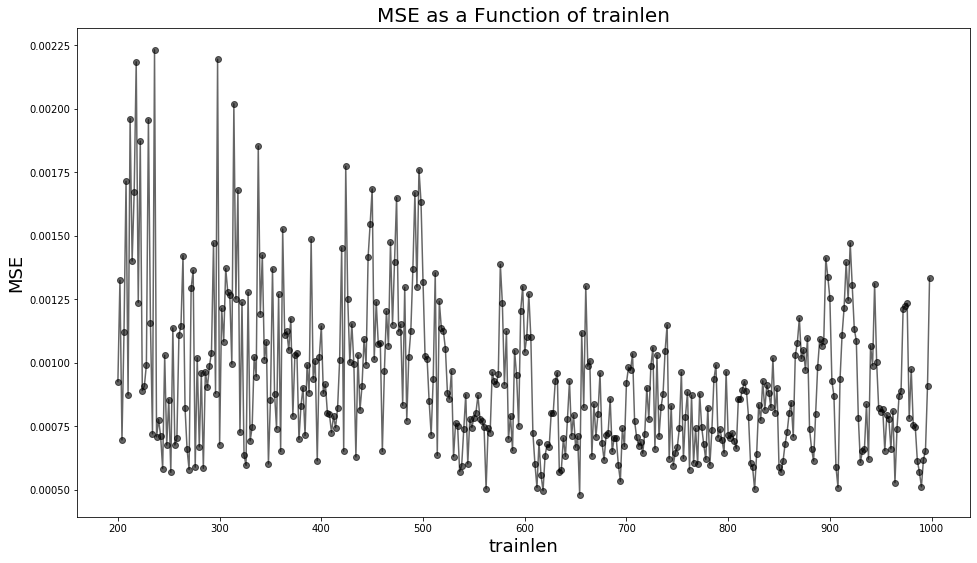

In [20]:
tic = time.perf_counter()
trainingLengths = np.arange(200,1000,2)
trainlen_loss = grid_optimizer(X_in.T,
                      params,
                      args=['trainlen'],
                      xset=trainingLengths,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds") 
print(f"This simulation took {elapsed/60:0.02f} minutes")